In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

Mounted at /content/drive


## Libraries

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load image's path and mask's path

In [3]:
import glob
images_path = glob.glob('/content/drive/MyDrive/AllMassFile/*.png')
mask_path = glob.glob('/content/drive/MyDrive/mask&images/*.png')

image_normal = glob.glob('/content/drive/MyDrive/normal/*.png')
mask_normal = glob.glob('/content/drive/MyDrive/normalmask/*.png')

In [4]:
MASS_PATIENT_ID = ['53586896', '22580192', '22614236', '22580098', '24055445', '30011674', 
                   '20586934', '22670465', '24055502', '22670673', '20587612', '22614568', 
                   '20587902', '22614522', '50995789', '24055464', '20588216', '51049053', 
                   '53582656', '20588562', '27829188', '22614431', '22580341', '22613822', 
                   '24065584', '50997515', '51049107', '22580367', '22580244', '50996352', 
                   '22670147', '22580732', '50999008', '24065707', '22614127', '20588334', 
                   '20588536', '24065530', '22670324', '20586908', '30011507', '27829134', 
                   '53581406', '50998981', '20586986', '22678787', '50997461', '53580804', 
                   '22579730', '22670094', '53580858', '53586869', '50995762', '24065251', 
                   '20587810', '53581460', '22670855', '22580706', '30011553', '22670809', 
                   '22580419', '24055355', '53587014', '50994408', '22614379', '22670278', 
                   '24065289', '22614074', '24055274', '22670511', '50994354', '20587928', 
                   '22580393', '22580654', '20588046', '50994273', '20587758', '24065761', 
                   '22427751', '20587664', '50999432', '22580680', '22580038', '53587663', 
                   '20588308', '20588680', '30011727', '22678833', '22427705', '22614266', 
                   '22613650', '50999459', '24055483', '22678694', '20587994', '22678646', 
                   '53582683', '20586960', '51048765', '22670620', '22613770', '22427840', 
                   '20588190', '53586960', '50996406', '22613702', '51048738']

In [5]:
import os
file_names_mask =[]
for filename in os.listdir('/content/drive/MyDrive/mask&images'):
    if filename.endswith(".png"):
          if filename[:8] in MASS_PATIENT_ID:
              file_names_mask.append('/content/drive/MyDrive/mask&images/'+filename)

In [6]:
len(file_names_mask)

107

In [7]:
file_names_mask.sort()

In [8]:
file_names_mass =[]
for filename in os.listdir('/content/drive/MyDrive/AllMassFile'):
    if filename.endswith(".png"):
          if filename[:8] in MASS_PATIENT_ID:
              file_names_mass.append('/content/drive/MyDrive/AllMassFile/'+filename)

In [9]:
len(file_names_mass)

107

In [10]:
file_names_mass.sort()

In [11]:
len(image_normal),len(mask_normal)

(107, 107)

In [12]:
image_normal.sort(),mask_normal.sort()

(None, None)

## Data Visualization

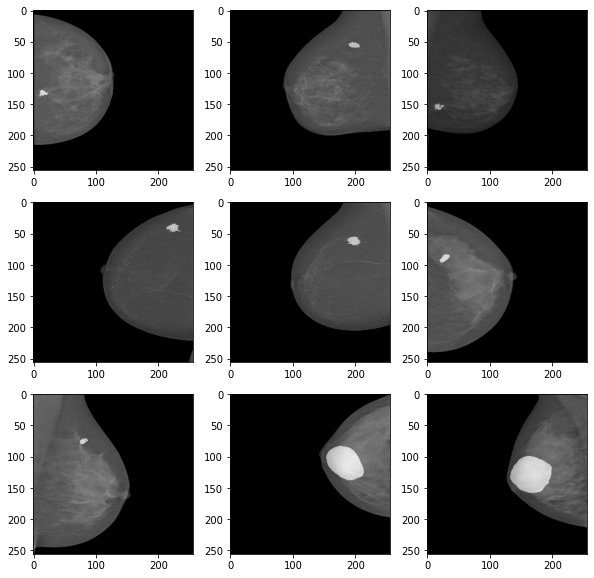

In [ ]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=file_names_mass[i]
    msk_path=file_names_mask[i]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(256,256))
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    msk=cv2.resize(msk,(256,256))
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

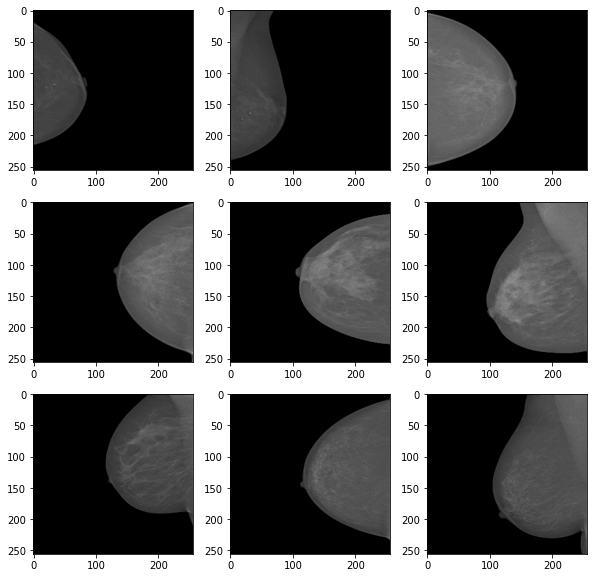

In [ ]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=image_normal[i]
    msk_path=mask_normal[i]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(256,256))
    # img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    msk=cv2.resize(msk,(256,256))
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

## Create data frame and split data on train set, validation set and test set

In [13]:
files = [*file_names_mass, *image_normal] 
mask = [*file_names_mask, *mask_normal] 

In [14]:
df = pd.DataFrame(data={"filename": files, 'mask' : mask})
shuffled = df.sample(frac=1)

df_train, df_test = train_test_split(shuffled,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(153, 2)
(39, 2)
(22, 2)


In [ ]:
shuffled

## Data genertator, data augmentation and adjust data

The steps_per_epoch parameter is key because an ImageDataGenerator can provide an infinite number of versions of each image. In this example, the batch_size parameter passed to flow tells the generator to create 10 images in each batch (each call to next). Dividing the number of images by the image batch size to calculate steps_per_epoch ensures that in each training epoch, the model is provided with one transformed version of each image in the dataset.

In [15]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(224,224),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

## Define loss function and metrics

In [16]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

## Define Unet

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Training

In [ ]:
# !pip3 install keras==2.3.1
!pip3 install -U segmentation-models

In [18]:
#Define the model
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [19]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)

In [27]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [28]:
# define model
model_resnet = sm.Unet(BACKBONE)
# model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model_resnet.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
print(model_resnet.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 add_35 (Add)                   (None, None, None,   0           ['stage2_unit1_conv2[0][0]',     
                                128)                              'stage2_unit1_sc[0][0]']        
                                                                                                  
 stage2_unit2_bn1 (BatchNormali  (None, None, None,   512        ['add_35[0][0]']                 
 zation)                        128)                                                              
                                                                                                  
 stage2_unit2_relu1 (Activation  (None, None, None,   0          ['stage2_unit2_bn1[0][0]']       
 )                              128)                                                              
                                                                                                  
 zero_padd

In [23]:
im_height = 224
im_width = 224

In [29]:
train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.05,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ModelCheckpoint/resenet_unet_segmentation.hdf5', verbose=1, save_best_only=True)]

history = history = model_resnet.fit(train_gen,
                    steps_per_epoch=10, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=10)

Found 153 validated image filenames.
Found 153 validated image filenames.
Epoch 1/150
10/10 [==============================] - ETA: 0s - loss: -0.0143 - binary_accuracy: 0.4691 - iou: 0.0074 - dice_coef: 0.0145Found 39 validated image filenames.
Found 39 validated image filenames.

Epoch 1: val_loss improved from inf to -0.00753, saving model to /content/drive/MyDrive/ModelCheckpoint/resenet_unet_segmentation.hdf5
10/10 [==============================] - 153s 15s/step - loss: -0.0143 - binary_accuracy: 0.4691 - iou: 0.0074 - dice_coef: 0.0145 - val_loss: -0.0075 - val_binary_accuracy: 0.0037 - val_iou: 0.0049 - val_dice_coef: 0.0095
Epoch 2/150
10/10 [==============================] - ETA: 0s - loss: -0.0172 - binary_accuracy: 0.5883 - iou: 0.0087 - dice_coef: 0.0171
Epoch 2: val_loss improved from -0.00753 to -0.00761, saving model to /content/drive/MyDrive/ModelCheckpoint/resenet_unet_segmentation.hdf5
10/10 [==============================] - 74s 8s/step - loss: -0.0172 - binary_accu

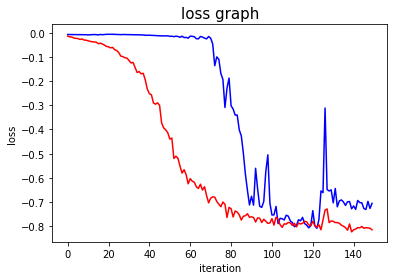

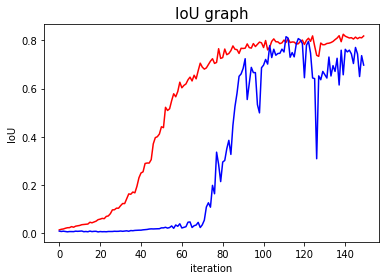

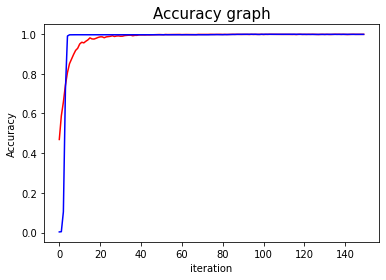

In [34]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)
plt.figure(3)
plt.plot( a['binary_accuracy'], 'r-')
plt.plot(a['val_binary_accuracy'], 'b-')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy graph', fontsize = 15)
plt.show()

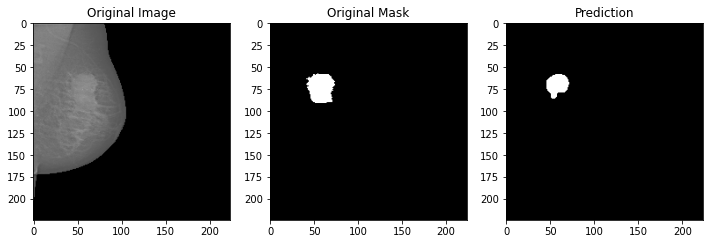

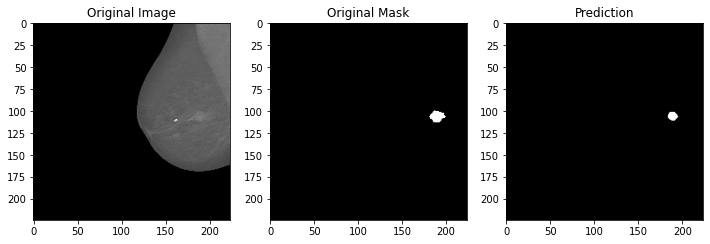

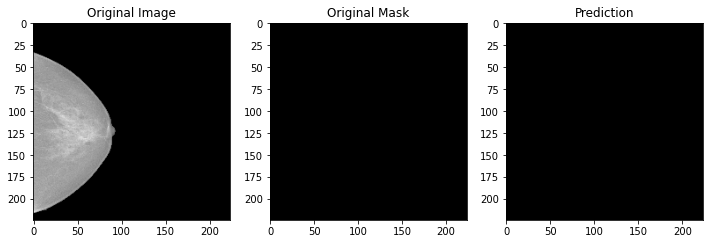

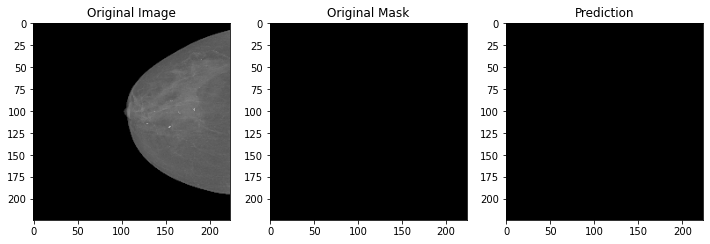

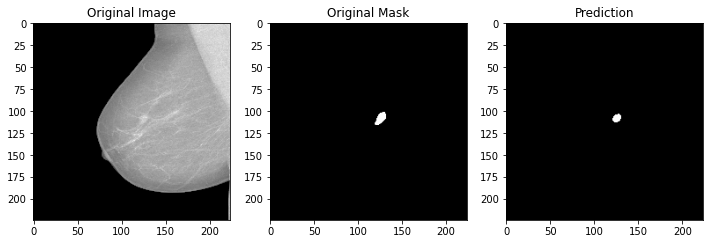

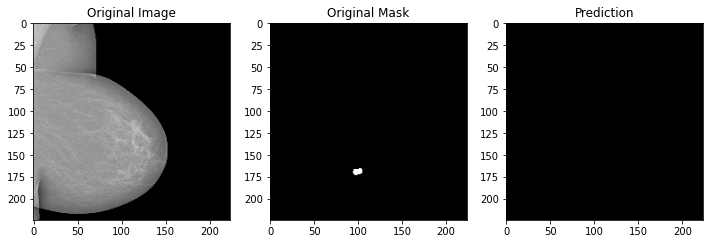

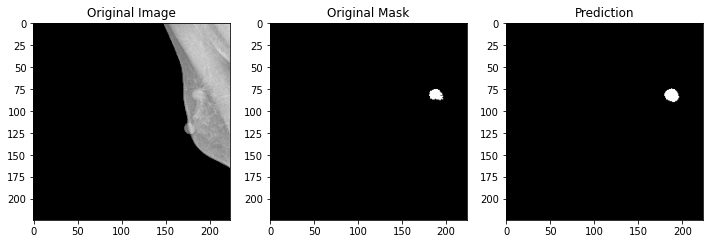

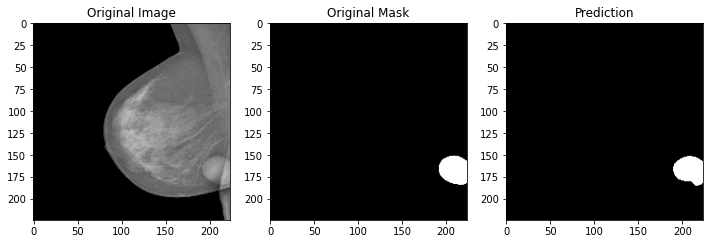

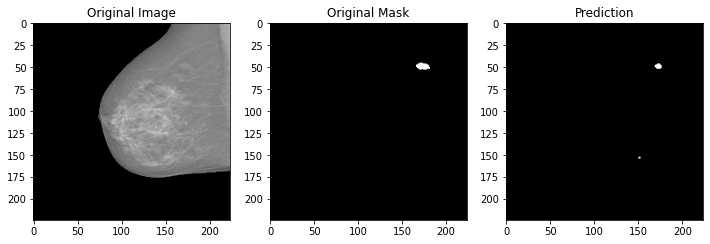

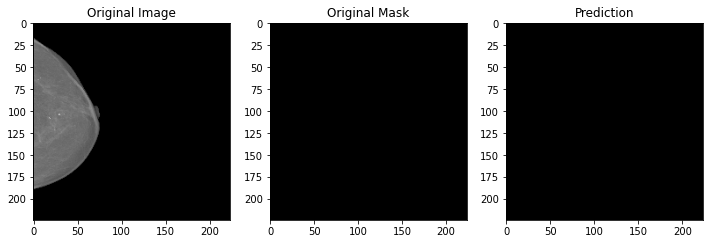

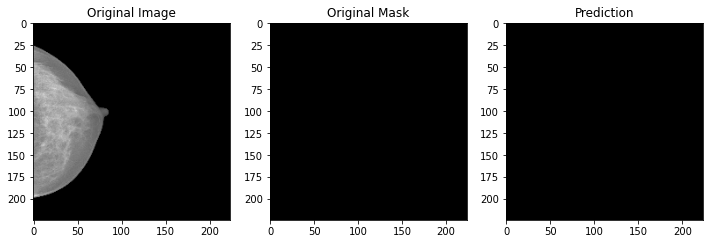

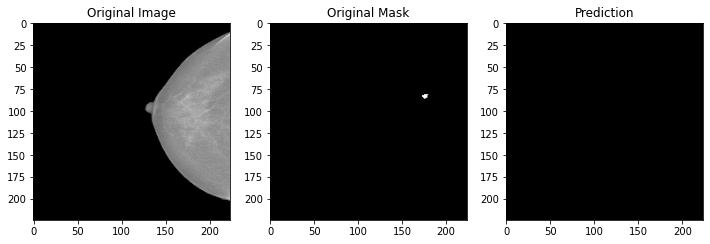

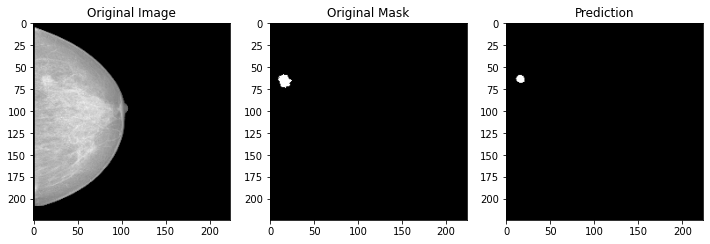

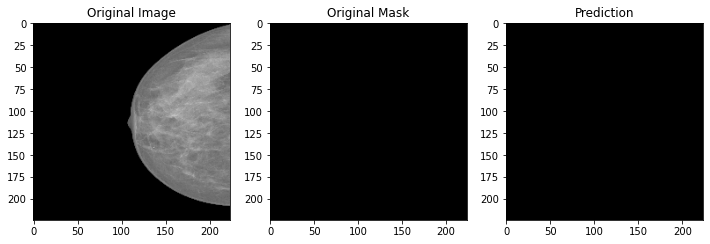

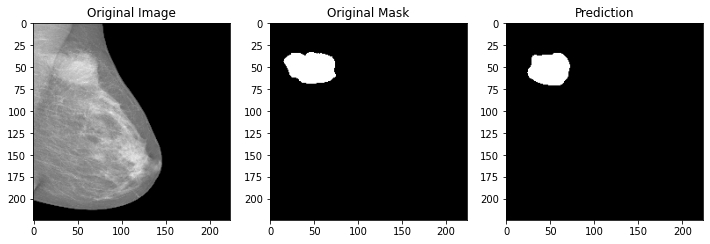

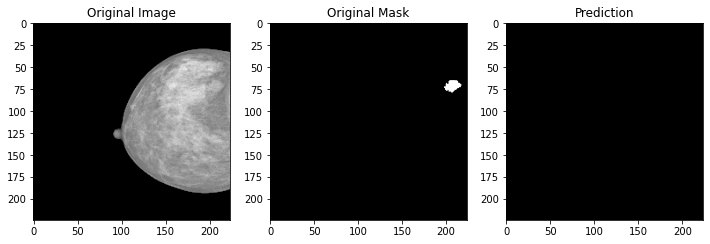

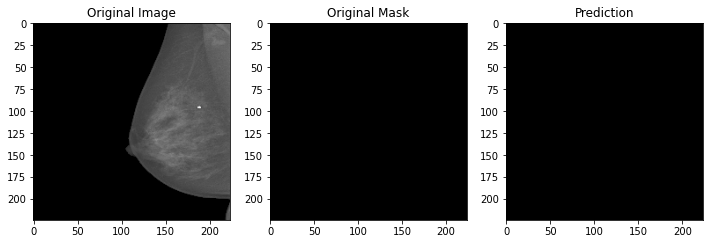

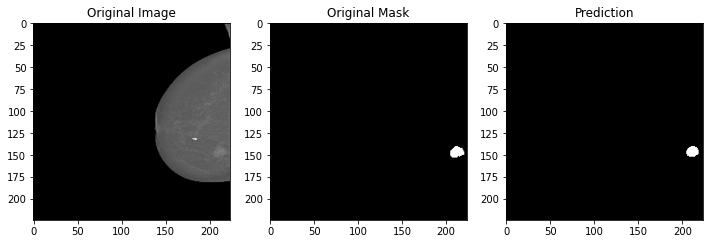

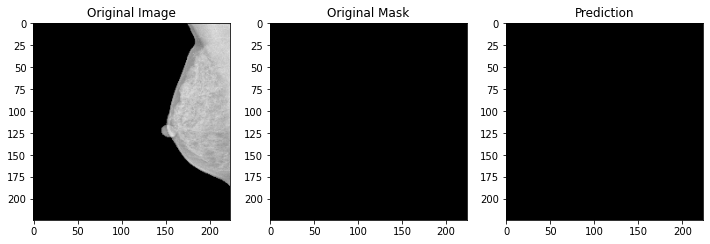

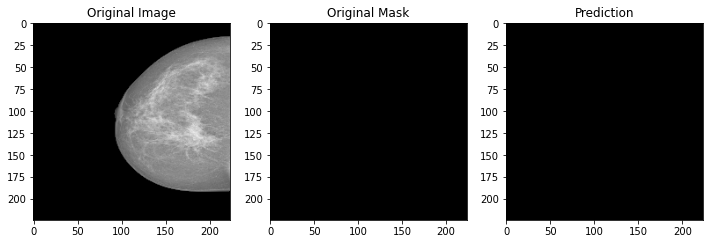

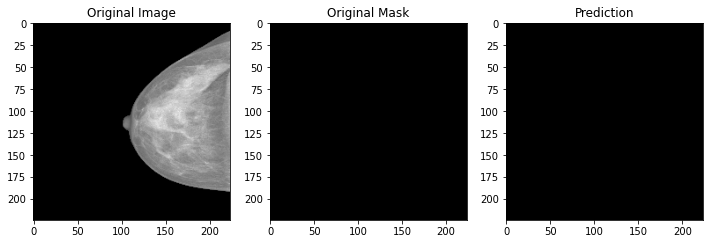

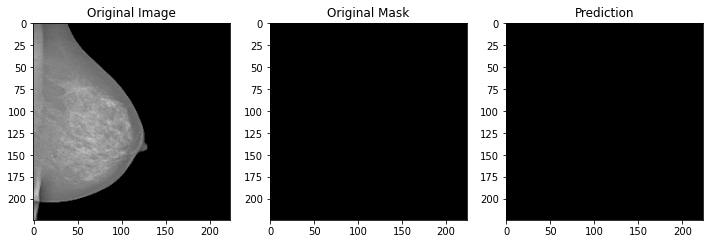

In [32]:
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model_resnet.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

## Loading Unet

In [ ]:
model = load_model('/content/drive/MyDrive/ModelCheckpoint/unet_segmentation.hdf5',
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=10)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

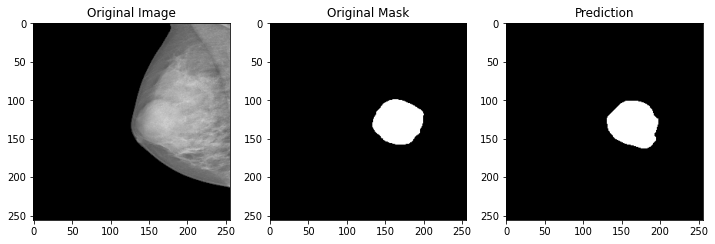

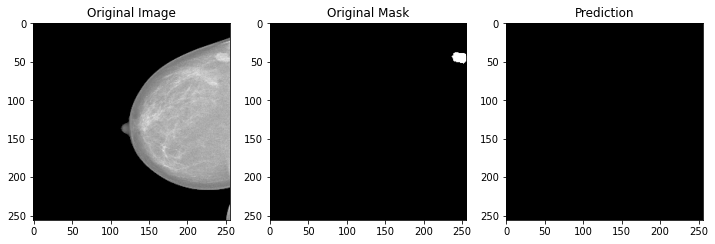

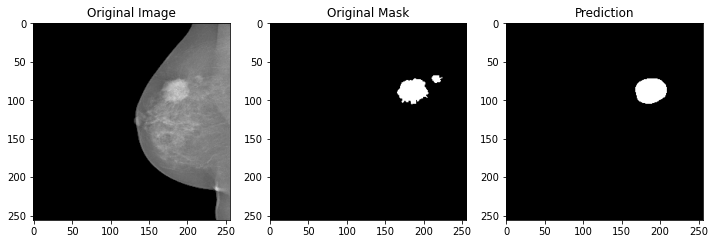

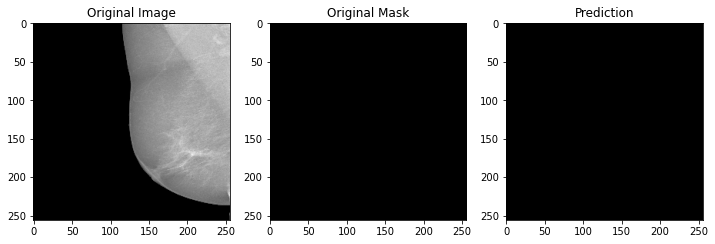

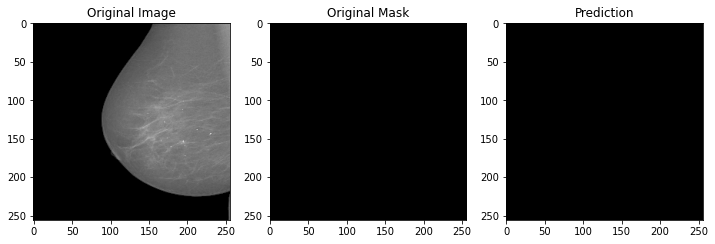

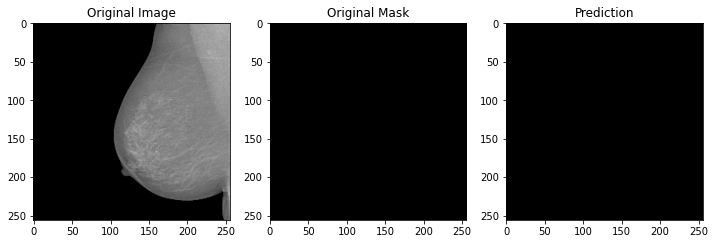

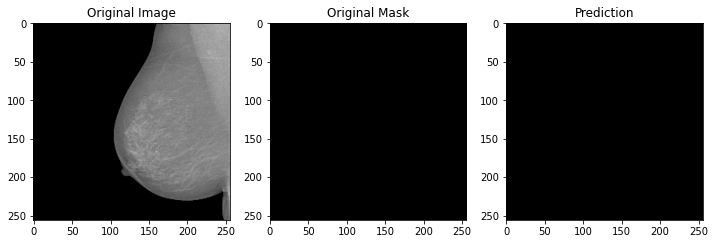

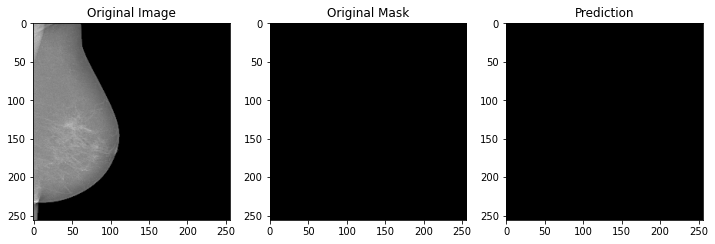

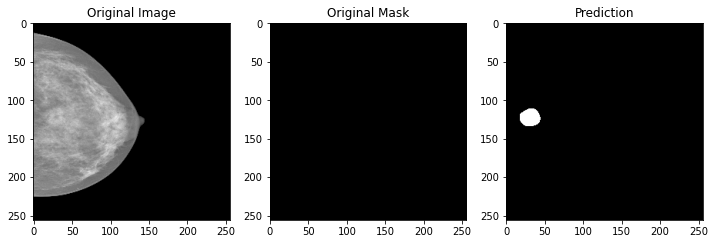

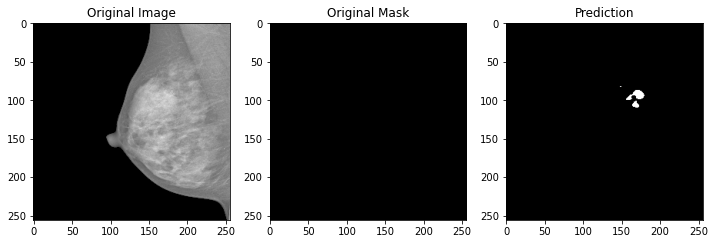

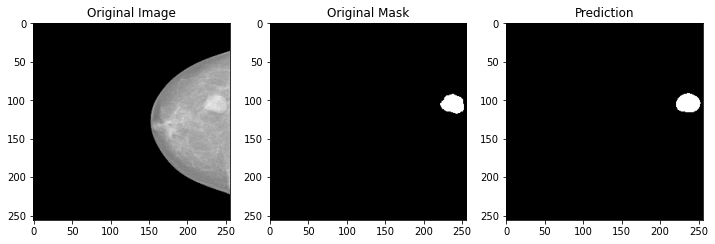

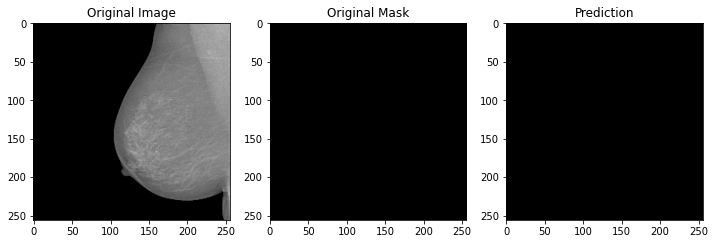

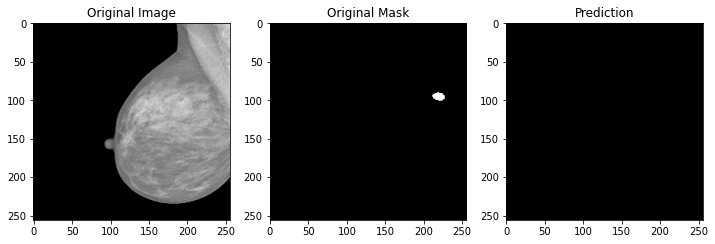

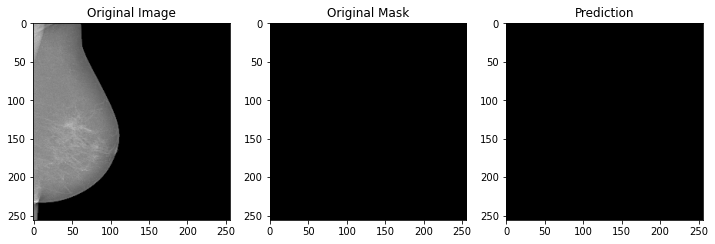

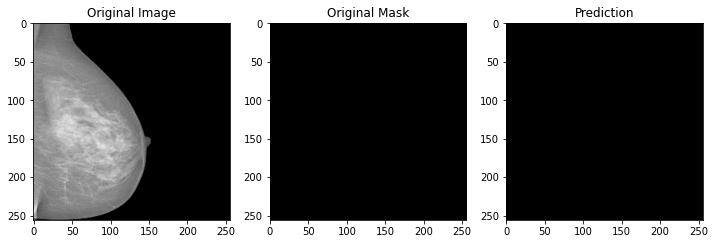

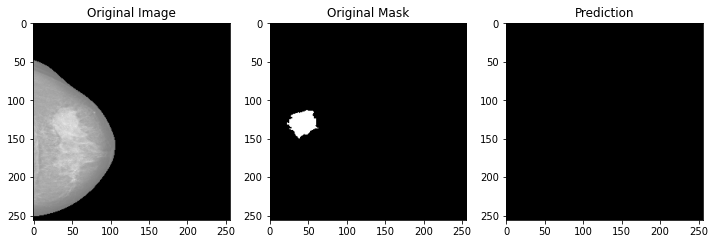

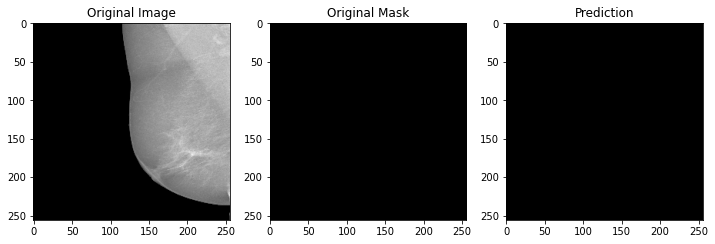

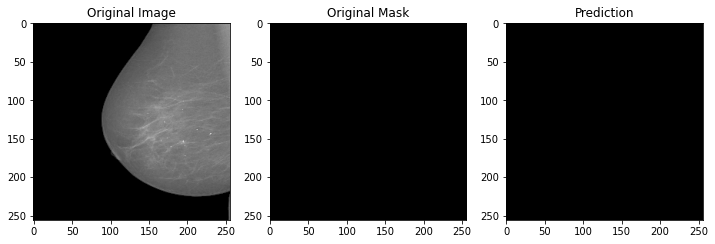

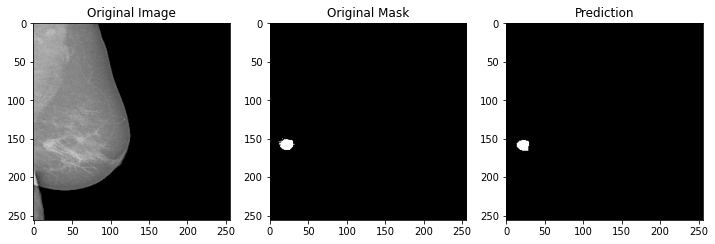

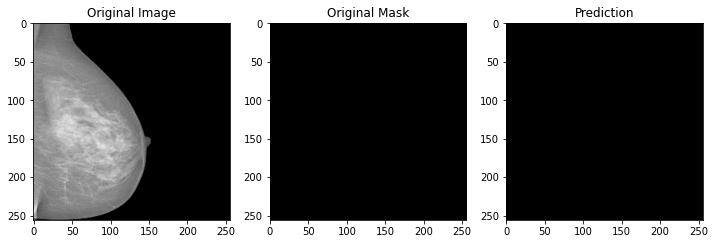

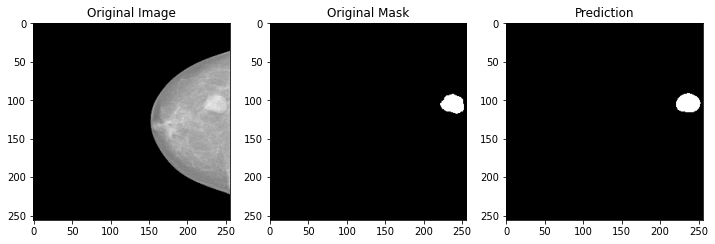

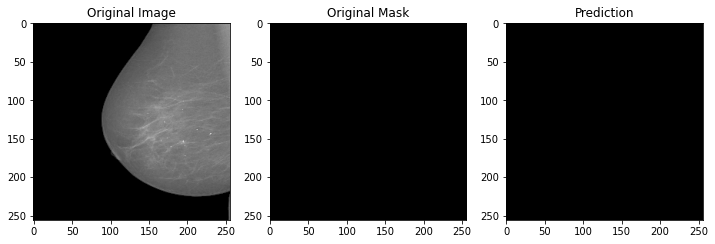

In [ ]:
im_height,im_width=256,256
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[index]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

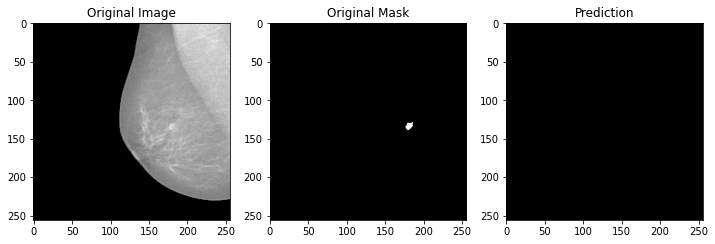

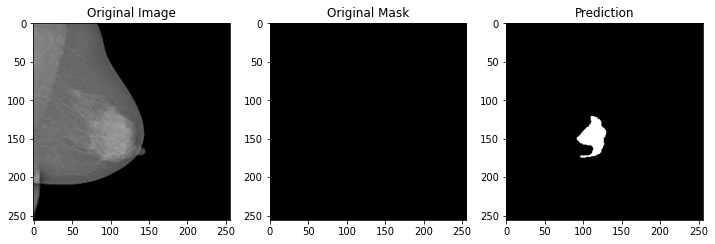

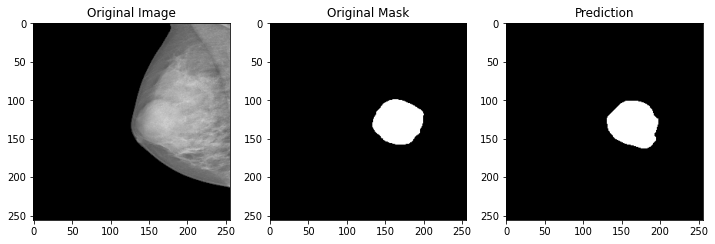

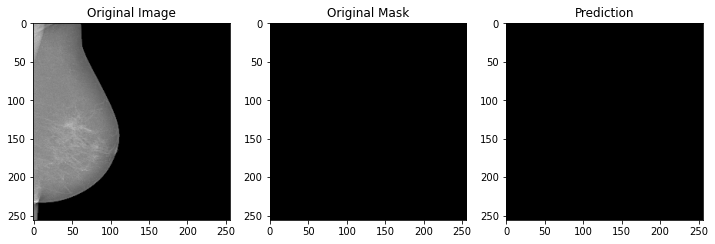

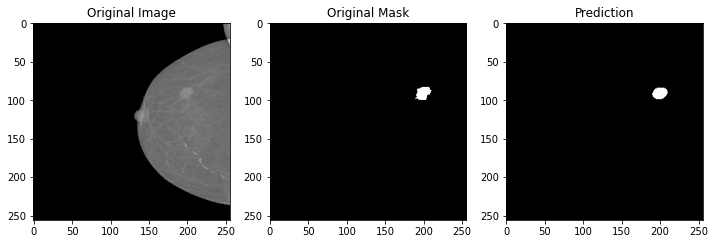

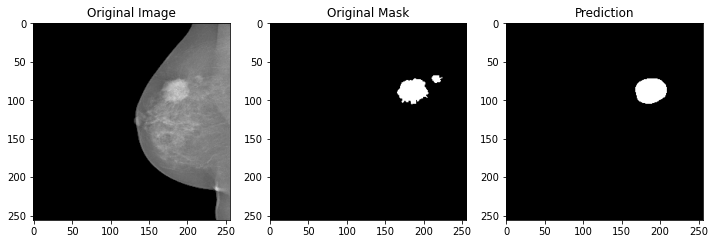

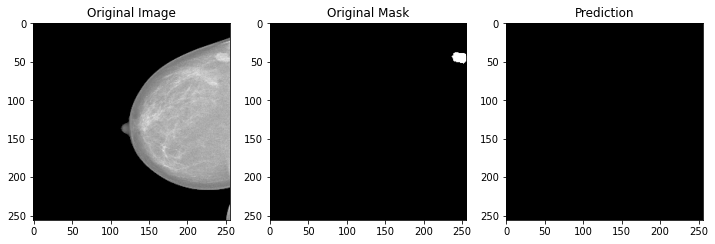

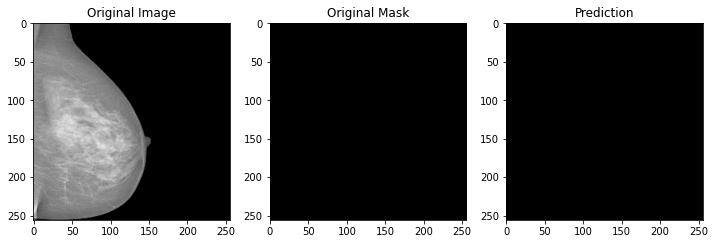

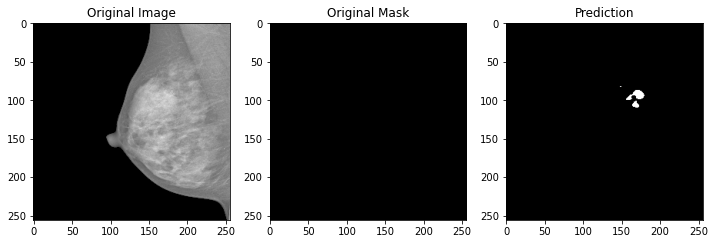

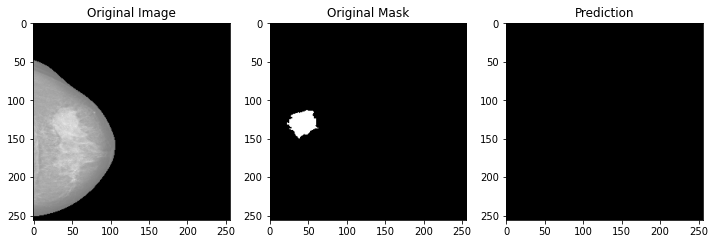

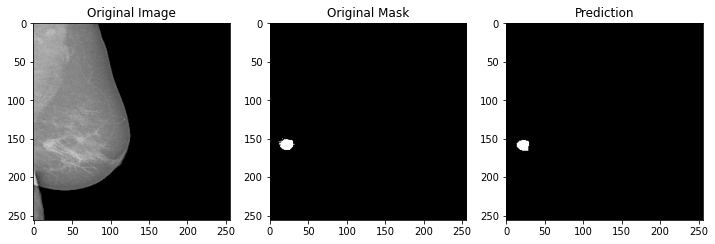

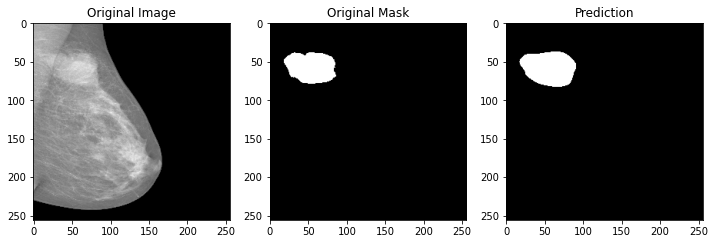

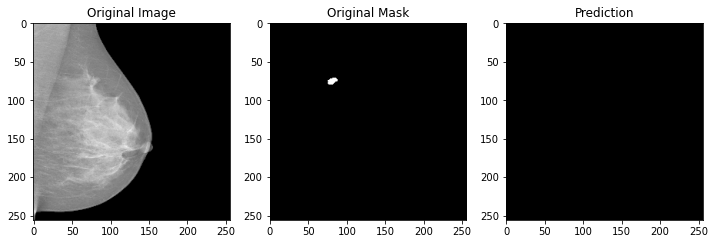

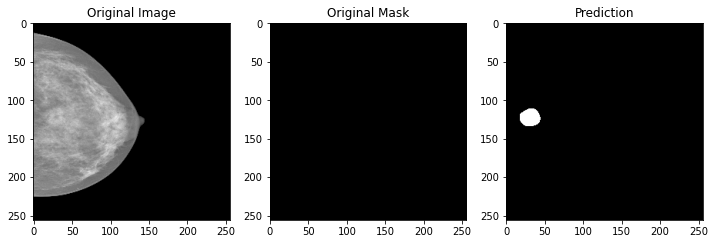

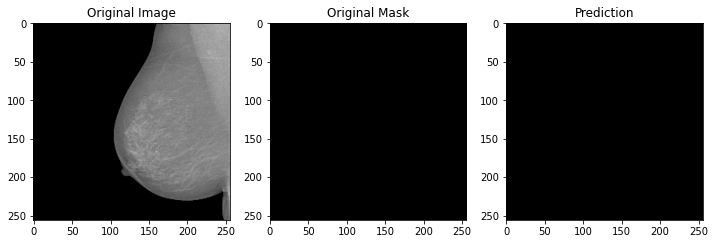

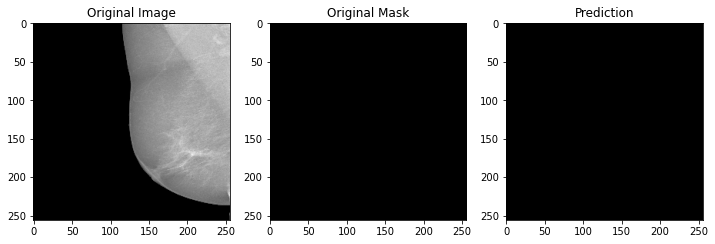

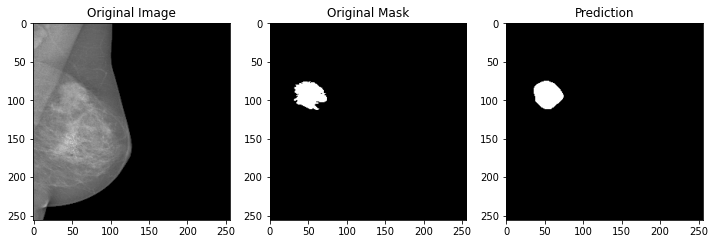

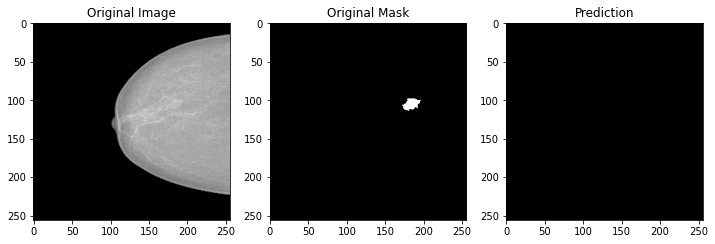

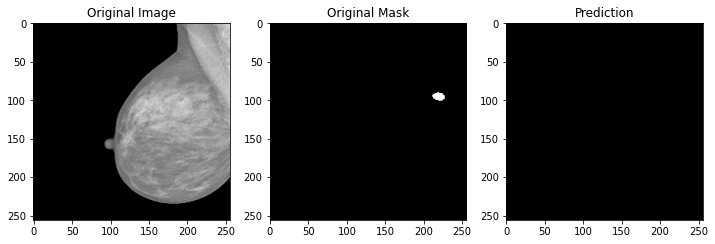

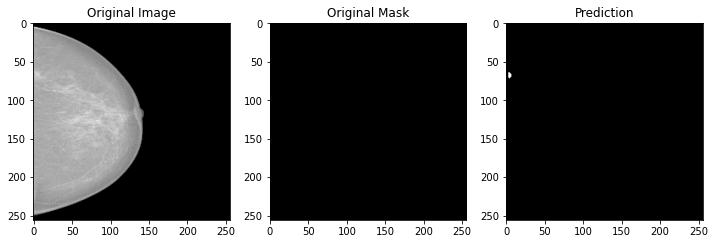

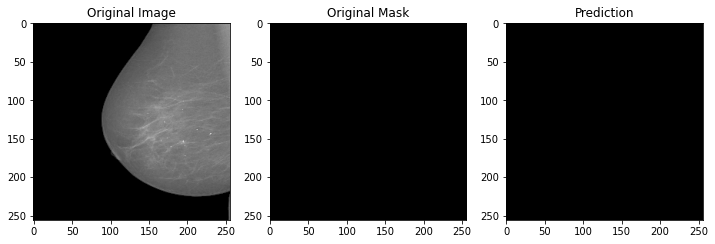

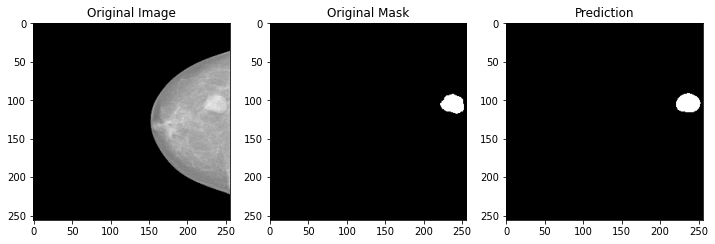

In [ ]:
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()

## Loading resnet

In [ ]:
model = load_model('/content/drive/MyDrive/ModelCheckpoint/resnet_unet_segmentation.hdf5',
                   custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
for i in range(22):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[i])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    mask = np.squeeze(cv2.imread(df_test['mask'].iloc[i]))
    mask = cv2.resize(mask ,(im_height, im_width))
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5,cmap='gray')
    plt.title('Prediction')
    plt.show()